**We want to prove that minimum energy disambiguation (SA numba) works**.

In [2]:
from minimum_energy import Disambiguator
import numpy as np
from numba import jit, prange
from scipy.fft import fft2, ifft2, fftfreq
import matplotlib.pyplot as plt
from astropy.io import fits
import time

1. FLOWER.

In [3]:
flower = fits.open('flower_field_polar_projections_corrected.fits')
theta = 0
Bx_true = flower[f'BX_{theta}'].data.astype(np.float64)
By_true = flower[f'BY_{theta}'].data.astype(np.float64)
Bz_true = flower[f'BZ_{theta}'].data.astype(np.float64)
print(Bz_true.shape)

subsample = 4
if subsample > 1:
    Bx_true = Bx_true[::subsample, ::subsample]
    By_true = By_true[::subsample, ::subsample]
    Bz_true = Bz_true[::subsample, ::subsample]
    print(f"Subsampled to: {Bx_true.shape}")
    
np.random.seed(42)
flip_mask_original = np.random.rand(*Bx_true.shape) < 0.5
    
Bx_ambig = np.where(flip_mask_original, -Bx_true, Bx_true)
By_ambig = np.where(flip_mask_original, -By_true, By_true)

disambiguator = Disambiguator(
    lambda_weight=1.0,
    dx=1.0, dy=1.0,
    tfac0=3.0,
   tfactr=0.95,
        jump=1,
        neq=100,
        seed=42,
        conv_check_window=10,
        conv_threshold=0.0001
)


Bx_dis, By_dis, info = disambiguator.disambiguate(
    Bx_true, By_true, Bz_true,
    verbose=True,
    max_iterations=500
)
print(f"Energy: {info['final_energy']:.2e}, Time: {info['total_time']:.1f}s")

(512, 512)
Subsampled to: (128, 128)
SA | Initial E: 8.98e+07
  Iter  20 | E: 1.101e+09 | T: 4.36e+06 | Accepted: 1352482
  Iter  40 | E: 7.461e+08 | T: 1.56e+06 | Accepted: 786422
  Iter  60 | E: 9.762e+07 | T: 5.61e+05 | Accepted: 37240
  Iter  80 | E: 9.039e+07 | T: 2.01e+05 | Accepted: 11429
  Iter 100 | E: 9.010e+07 | T: 7.20e+04 | Accepted: 5414
SA complete | 92.3s | Final E: 9.01e+07 | 110 iterations
Energy: 9.01e+07, Time: 92.3s


Correlation coefficient for Bx: 0.9844
Correlation coefficient for By: 0.9829


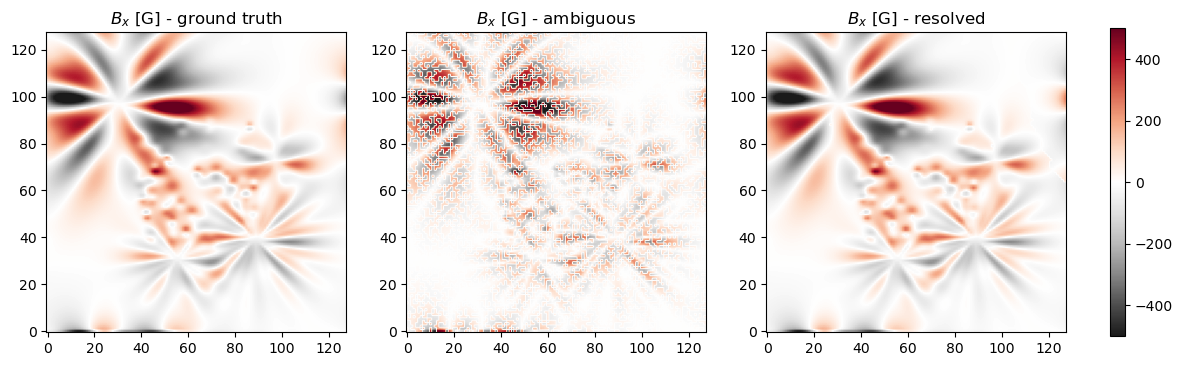

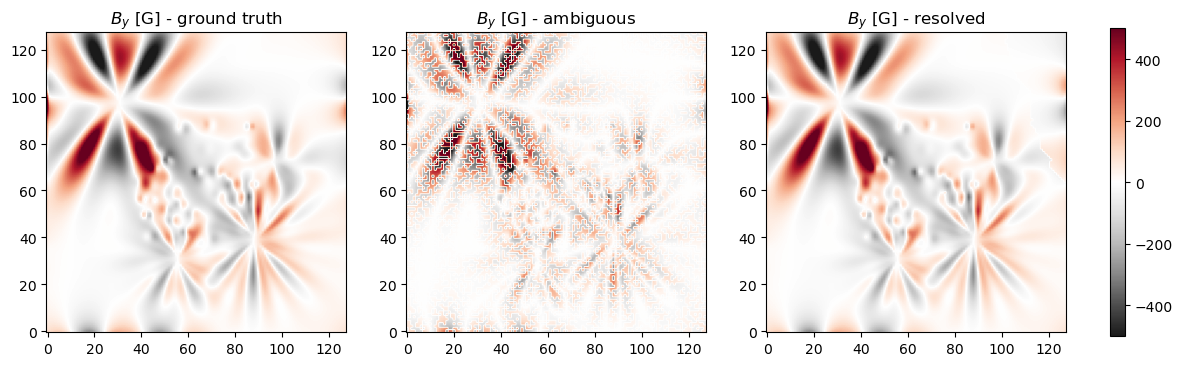

Ambiguous Bx correlation: -0.0007
Number of flips applied: 8281


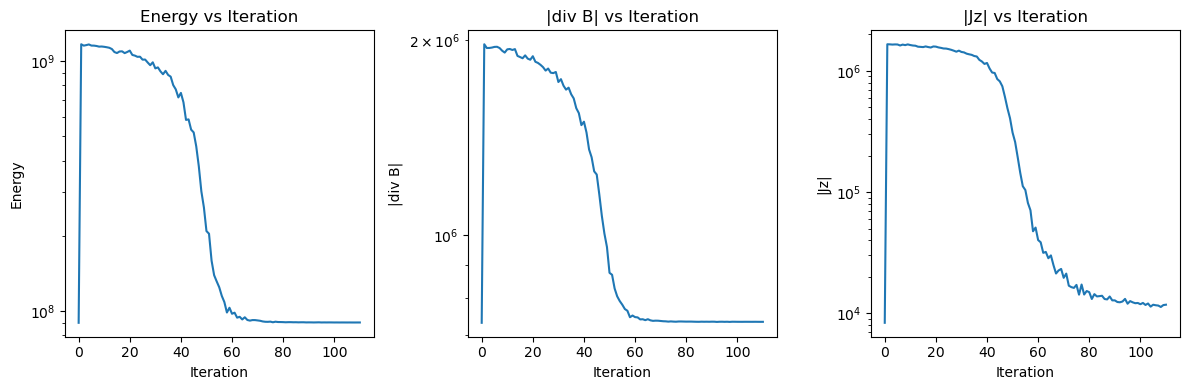

In [4]:
corr_coef = np.corrcoef(Bx_true.flatten(), Bx_dis.flatten())[0, 1]
print(f"Correlation coefficient for Bx: {corr_coef:.4f}")   
corr_coef = np.corrcoef(By_true.flatten(), By_dis.flatten())[0, 1]
print(f"Correlation coefficient for By: {corr_coef:.4f}")

vmin_x, vmax_x = -500, 500
vmin_y, vmax_y = -500, 500

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
im1 = plt.imshow(Bx_true, origin='lower', cmap='RdGy_r', vmin=vmin_x, vmax=vmax_x)
plt.title(r'$B_x$ [G] - ground truth', fontsize=12)
plt.subplot(1, 3, 2)
im2 = plt.imshow(Bx_ambig, origin='lower', cmap='RdGy_r', vmin=vmin_x, vmax=vmax_x)
plt.title(r'$B_x$ [G] - ambiguous', fontsize=12)
plt.subplot(1, 3, 3)
im3 = plt.imshow(Bx_dis, origin='lower', cmap='RdGy_r', vmin=vmin_x, vmax=vmax_x)
plt.title(r'$B_x$ [G] - resolved', fontsize=12)
fig = plt.gcf()
cbar = fig.colorbar(im3, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(By_true, origin='lower', cmap='RdGy_r', vmin=vmin_y, vmax=vmax_y)
plt.title(r'$B_y$ [G] - ground truth', fontsize=12)
plt.subplot(1, 3, 2)
im2 = plt.imshow(By_ambig, origin='lower', cmap='RdGy_r', vmin=vmin_y, vmax=vmax_y)
plt.title(r'$B_y$ [G] - ambiguous', fontsize=12)
plt.subplot(1, 3, 3)
im3 = plt.imshow(By_dis, origin='lower', cmap='RdGy_r', vmin=vmin_y, vmax=vmax_y)
plt.title(r'$B_y$ [G] - resolved', fontsize=12)
fig = plt.gcf()
cbar = fig.colorbar(im3, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

print(f"Ambiguous Bx correlation: {np.corrcoef(Bx_true.flatten(), Bx_ambig.flatten())[0,1]:.4f}")
print(f"Number of flips applied: {np.sum(flip_mask_original)}")

E, divB, jz = np.loadtxt('SA_behaviour.txt', unpack=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(E)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy vs Iteration')
plt.subplot(1, 3, 2)
plt.plot(divB)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('|div B|')
plt.title('|div B| vs Iteration')
plt.subplot(1, 3, 3)
plt.plot(jz)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('|Jz|')
plt.title('|Jz| vs Iteration')  
plt.tight_layout()
plt.show()

2. REALISTIC.

In [5]:
nsnaps = 163
nx = 384
ny = 384
snapshot = 50
    
    
Bx_true = np.memmap('layers_downsampled/tau_0.010_bx.dat', dtype=np.float32, mode='r', shape=(nsnaps, nx, ny))
By_true = np.memmap('layers_downsampled/tau_0.010_by.dat', dtype=np.float32, mode='r', shape=(nsnaps, nx, ny))
Bz_true = np.memmap('layers_downsampled/tau_0.010_bz.dat', dtype=np.float32, mode='r', shape=(nsnaps, nx, ny))
Bx_true = Bx_true[snapshot]
By_true = By_true[snapshot]
Bz_true = Bz_true[snapshot]
print(Bz_true.shape)

subsample = 3
if subsample > 1:
    Bx_true = Bx_true[::subsample, ::subsample]
    By_true = By_true[::subsample, ::subsample]
    Bz_true = Bz_true[::subsample, ::subsample]
    print(f"Subsampled to: {Bx_true.shape}")
    
np.random.seed(42)
flip_mask_original = np.random.rand(*Bx_true.shape) < 0.5
    
Bx_ambig = np.where(flip_mask_original, -Bx_true, Bx_true)
By_ambig = np.where(flip_mask_original, -By_true, By_true)

disambiguator = Disambiguator(
    lambda_weight=1.0,
    dx=1.0, dy=1.0,
    tfac0=3.0,
   tfactr=0.95,
        jump=1,
        neq=100,
        seed=42,
        conv_check_window=10,
        conv_threshold=0.0001
)


Bx_dis, By_dis, info = disambiguator.disambiguate(
    Bx_true, By_true, Bz_true,
    verbose=True,
    max_iterations=500
)

print(f"Energy: {info['final_energy']:.2e}, Time: {info['total_time']:.1f}s")

(384, 384)
Subsampled to: (128, 128)
SA | Initial E: 4.86e+07
  Iter  20 | E: 3.810e+08 | T: 1.43e+06 | Accepted: 1255021
  Iter  40 | E: 2.511e+08 | T: 5.13e+05 | Accepted: 723923
  Iter  60 | E: 4.907e+07 | T: 1.84e+05 | Accepted: 169587
  Iter  80 | E: 4.601e+07 | T: 6.59e+04 | Accepted: 81218
  Iter 100 | E: 4.581e+07 | T: 2.36e+04 | Accepted: 39353
  Iter 120 | E: 4.577e+07 | T: 8.47e+03 | Accepted: 17494
SA complete | 114.6s | Final E: 4.58e+07 | 130 iterations
Energy: 4.58e+07, Time: 114.6s


Correlation coefficient for Bx: 0.9903
Correlation coefficient for By: 0.9903


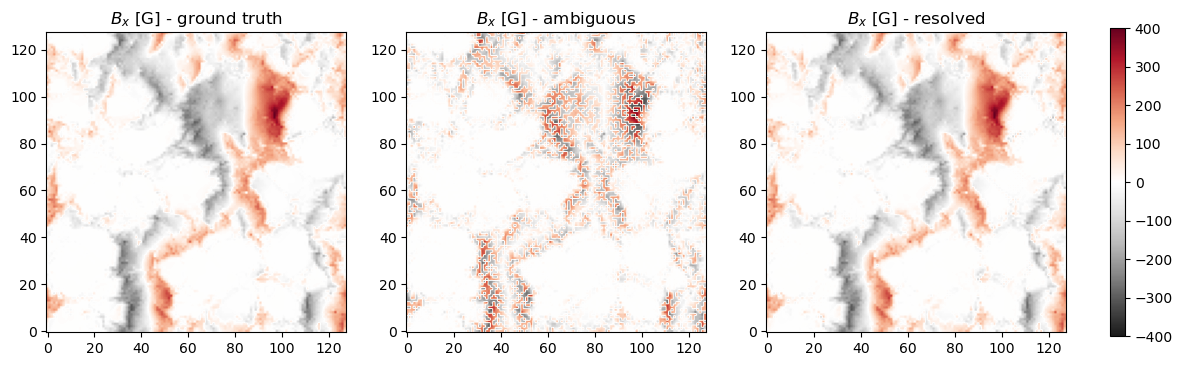

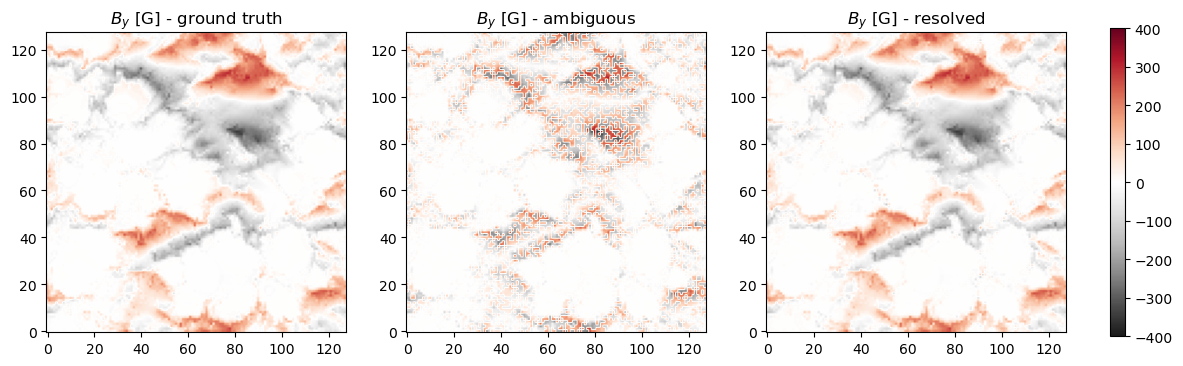

Ambiguous Bx correlation: -0.0321
Number of flips applied: 8281


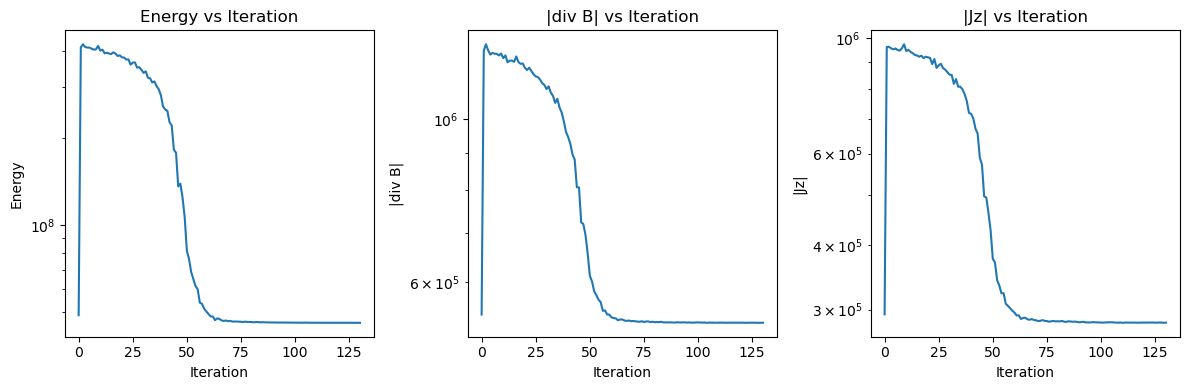

In [6]:
corr_coef = np.corrcoef(Bx_true.flatten(), Bx_dis.flatten())[0, 1]
print(f"Correlation coefficient for Bx: {corr_coef:.4f}")   
corr_coef = np.corrcoef(By_true.flatten(), By_dis.flatten())[0, 1]
print(f"Correlation coefficient for By: {corr_coef:.4f}")

vmin_x, vmax_x = -400, 400
vmin_y, vmax_y = -400, 400

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
im1 = plt.imshow(Bx_true.T, origin='lower', cmap='RdGy_r', vmin=vmin_x, vmax=vmax_x)
plt.title(r'$B_x$ [G] - ground truth', fontsize=12)
plt.subplot(1, 3, 2)
im2 = plt.imshow(Bx_ambig.T, origin='lower', cmap='RdGy_r', vmin=vmin_x, vmax=vmax_x)
plt.title(r'$B_x$ [G] - ambiguous', fontsize=12)
plt.subplot(1, 3, 3)
im3 = plt.imshow(Bx_dis.T, origin='lower', cmap='RdGy_r', vmin=vmin_x, vmax=vmax_x)
plt.title(r'$B_x$ [G] - resolved', fontsize=12)
fig = plt.gcf()
cbar = fig.colorbar(im3, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(By_true.T, origin='lower', cmap='RdGy_r', vmin=vmin_y, vmax=vmax_y)
plt.title(r'$B_y$ [G] - ground truth', fontsize=12)
plt.subplot(1, 3, 2)
im2 = plt.imshow(By_ambig.T, origin='lower', cmap='RdGy_r', vmin=vmin_y, vmax=vmax_y)
plt.title(r'$B_y$ [G] - ambiguous', fontsize=12)
plt.subplot(1, 3, 3)
im3 = plt.imshow(By_dis.T, origin='lower', cmap='RdGy_r', vmin=vmin_y, vmax=vmax_y)
plt.title(r'$B_y$ [G] - resolved', fontsize=12)
fig = plt.gcf()
cbar = fig.colorbar(im3, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

print(f"Ambiguous Bx correlation: {np.corrcoef(Bx_true.flatten(), Bx_ambig.flatten())[0,1]:.4f}")
print(f"Number of flips applied: {np.sum(flip_mask_original)}")

E, divB, jz = np.loadtxt('SA_behaviour.txt', unpack=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(E)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy vs Iteration')
plt.subplot(1, 3, 2)
plt.plot(divB)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('|div B|')
plt.title('|div B| vs Iteration')
plt.subplot(1, 3, 3)
plt.plot(jz)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('|Jz|')
plt.title('|Jz| vs Iteration')  
plt.tight_layout()
plt.show()